# Predicting Won/Dollar Exchange Rate

## Loading Modules

In [1]:
import pandas as pd
import pandas_datareader.data as pdr
import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import argparse
from copy import deepcopy # Add Deepcopy for args
from sklearn.metrics import mean_absolute_error
import time
import scipy.signal
from sklearn.preprocessing import RobustScaler

import seaborn as sns 
import matplotlib.pyplot as plt

print(torch.__version__)
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

1.12.1+cu113
Populating the interactive namespace from numpy and matplotlib


## Loading Dataset

### Data Preprocessing

In [2]:
from google.colab import files
myfile = files.upload()

Saving wondollarweek.csv to wondollarweek.csv


In [3]:
myfile

{'wondollarweek.csv': b'\xef\xbb\xbf1186,1174,1181.5,1180,1174.5,1175.4,1181.9,1224,1242,1233.8,1220.8,1223,1224.6,1223.1,1204,1186,1190.1,1198,1200.5,1187,1187,1178.5,1165.9,1159.4,1157,1168,1176,1193,1203.1,1198.3,1199,1205.8,1199,1184.6,1193.5,1192.3,1204.5,1216.4,1202,1208.5,1205.4,1199.7,1184.9,1173.1,1173.2,1158.2,1150,1131,1131.3,1130.7,1138,1133.9,1121,1124,1123.2,1129.3,1127,1134,1131,1119,1118.3,1113,1109.4,1112,1111.3,1108.5,1109.1,1109.4,1115,1133,1129.4,1115.3,1115,1118.8,1114.9,1117.2,1111.9,1112.8,1116.6,1115.2,1115.4,1114.5,1111.8,1104.4,1115.1,1128.1,1115.8,1116.2,1128.6,1128.5,1135.9,1133.6,1134.6,1141.8,1188.1,1209.5,1190.3,1207,1237,1276.4,1255.1,1283.5,1280.3,1249.5,1261.6,1243.5,1248.5,1273.3,1278.4,1299.2,1310.5,1348.8,1334.1,1324.1,1307,1302.8,1301.8,1309.3,1285,1289.5,1286.1,1291.7,1302.9,1303.2,1296.6,1300.7,1305.6,1300.8,1288.7,1283.5,1286.1,1280.9,1280.1,1290.3,1298.7,1307.2,1313.1,1302,1298.5,1297,1298,1285.1,1283.3,1276.8,1269,1274.4,1274.6,1300.2,1323,130

In [4]:
prac_data = str(myfile.values()).replace("dict_values([b'\\xef\\xbb\\xbf", '').replace(' ,,', ' ,').replace("'])", '').split(',')
float_lst = []
for item in prac_data:
    float_lst.append(float(item))
    
print(float_lst)
print(len(float_lst))

[1186.0, 1174.0, 1181.5, 1180.0, 1174.5, 1175.4, 1181.9, 1224.0, 1242.0, 1233.8, 1220.8, 1223.0, 1224.6, 1223.1, 1204.0, 1186.0, 1190.1, 1198.0, 1200.5, 1187.0, 1187.0, 1178.5, 1165.9, 1159.4, 1157.0, 1168.0, 1176.0, 1193.0, 1203.1, 1198.3, 1199.0, 1205.8, 1199.0, 1184.6, 1193.5, 1192.3, 1204.5, 1216.4, 1202.0, 1208.5, 1205.4, 1199.7, 1184.9, 1173.1, 1173.2, 1158.2, 1150.0, 1131.0, 1131.3, 1130.7, 1138.0, 1133.9, 1121.0, 1124.0, 1123.2, 1129.3, 1127.0, 1134.0, 1131.0, 1119.0, 1118.3, 1113.0, 1109.4, 1112.0, 1111.3, 1108.5, 1109.1, 1109.4, 1115.0, 1133.0, 1129.4, 1115.3, 1115.0, 1118.8, 1114.9, 1117.2, 1111.9, 1112.8, 1116.6, 1115.2, 1115.4, 1114.5, 1111.8, 1104.4, 1115.1, 1128.1, 1115.8, 1116.2, 1128.6, 1128.5, 1135.9, 1133.6, 1134.6, 1141.8, 1188.1, 1209.5, 1190.3, 1207.0, 1237.0, 1276.4, 1255.1, 1283.5, 1280.3, 1249.5, 1261.6, 1243.5, 1248.5, 1273.3, 1278.4, 1299.2, 1310.5, 1348.8, 1334.1, 1324.1, 1307.0, 1302.8, 1301.8, 1309.3, 1285.0, 1289.5, 1286.1, 1291.7, 1302.9, 1303.2, 1296.6,

In [5]:
mydf = pd.DataFrame(float_lst)

In [6]:
class MyDataset(Dataset):
    
    def __init__(self, x_frames, y_frames, data, start, end):
        
        self.x_frames = x_frames
        self.y_frames = y_frames
        self.data = data
        self.start = start
        self.end = end

        self.data = data.iloc[start : end]
        
    def __len__(self):
        return len(self.data) - (self.x_frames + self.y_frames) + 1
    
    def __getitem__(self, idx):
        idx += self.x_frames
        data = self.data.iloc[idx-self.x_frames:idx+self.y_frames].values
        X = data[:self.x_frames]
        y = data[self.x_frames:]
        
        return X, y

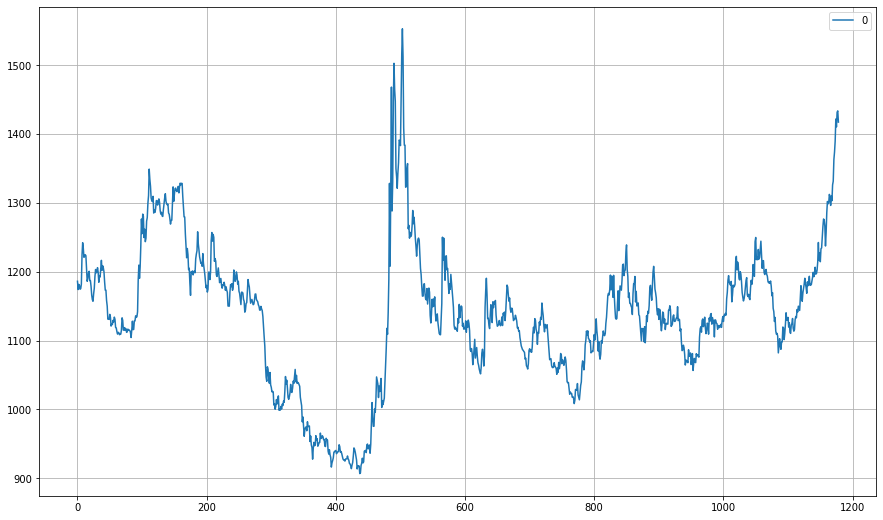

In [7]:
mydf.plot(grid=True)

### Filtering & Nomalizing Dataset

#### sklearn에서 제공하는 Scaler에는 크게 세 가지가 있음.
#### Standard, MinMax, Robust
#### 이상치가 있는 시계열 자료에 가장 적합한 것이 Robust Scaler: 3분위 값, 1분위 값 기준으로 scaling

#### Denoising Filter를 사용하지 않으면, Lagging Problem이 발생
#### Moving Average가 잘 알려져 있는데, 이 방법으로는 위 문제를 해결할 수 없음.
#### Savitzky-Golay Filter 사용

In [8]:
scaler = RobustScaler()
df_robust = scaler.fit_transform(mydf[-1000:])

#### 계산의 편의를 위해 5000일의 데이터를 사용

In [9]:
print(df_robust.shape)
mydf.shape

(1000, 1)


(1179, 1)

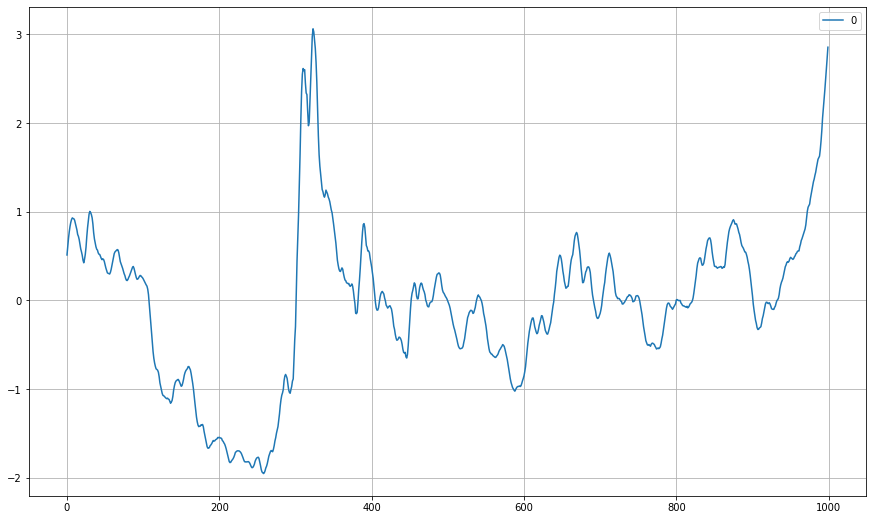

In [10]:
df_s = scipy.signal.savgol_filter(np.ravel(df_robust), 15, 2)
mydata = pd.DataFrame(df_s)
mydata.plot(grid = True)

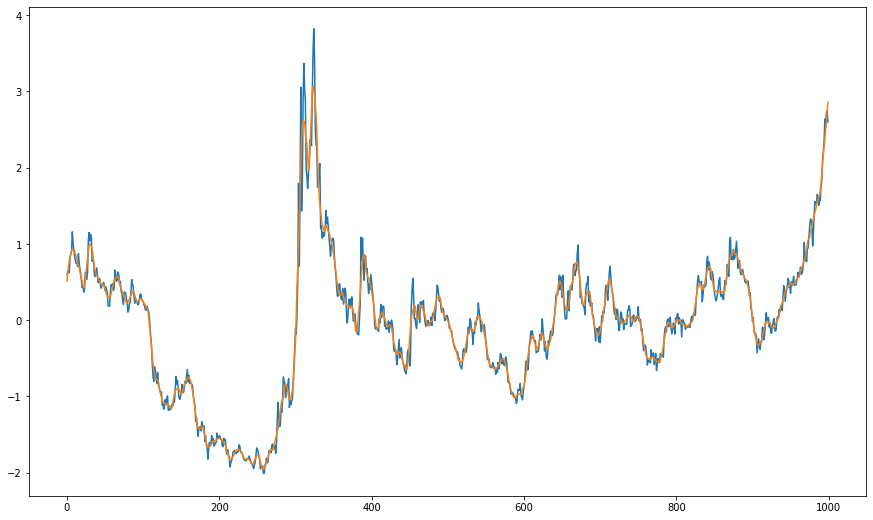

In [11]:
plt.plot(df_robust)
plt.plot(mydata.to_numpy())

#### Filter와 Scaler를 적용한 값 = 주황색
#### Scaler만 적용한 값 = 파란색
#### -> Filter 적용시 denoising이 일어났음을 확인할 수 있음.

## Defining Necessary Classes

#### LSTM 모형 사용: 시계열 데이터 예측에서 가장 널리 쓰이는 딥러닝 방법론

In [12]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size, dropout, use_bn):
        super(LSTM, self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.batch_size = batch_size
        self.dropout = dropout
        self.use_bn = use_bn 
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.hidden = self.init_hidden()
        self.regressor = self.make_regressor()
        
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    
    def make_regressor(self):
        layers = []
        if self.use_bn:
            layers.append(nn.BatchNorm1d(self.hidden_dim))
        layers.append(nn.Dropout(self.dropout))
        
        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim // 2))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim // 2, self.output_dim))
        regressor = nn.Sequential(*layers)
        return regressor
    
    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y_pred = self.regressor(lstm_out[-1].view(self.batch_size, -1))
        return y_pred

#### LSTM 학습에 필요한 train, validation, test 함수

In [13]:
def train(model, partition, optimizer, loss_fn, args):
    trainloader = DataLoader(partition['train'], 
                             batch_size=args.batch_size, 
                             shuffle=True, drop_last=True)
    model.train()
    model.zero_grad()
    optimizer.zero_grad()

    train_loss = 0.0
    for i, (X, y) in enumerate(trainloader):
        X = X.transpose(0, 1).float().to(args.device)
        y_true = y.float().to(args.device)

        model.zero_grad()
        optimizer.zero_grad()
        model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

        y_pred = model(X)
        loss = torch.sqrt(loss_fn(y_pred.view(-1), y_true.view(-1)))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss = train_loss / len(trainloader)
    return model, train_loss

In [14]:
def validate(model, partition, loss_fn, args):
    valloader = DataLoader(partition['val'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(valloader):
            X = X.transpose(0, 1).float().to(args.device)
            y_true = y.float().to(args.device)
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            loss = torch.sqrt(loss_fn(y_pred.view(-1), y_true.view(-1)))

            val_loss += loss.item()

    val_loss = val_loss / len(valloader)
    return val_loss

In [15]:
def test(model, partition, args):
    testloader = DataLoader(partition['test'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):

            X = X.transpose(0, 1).float().to(args.device)
            y_true = y.float().to(args.device)
            y_true1 = y_true[:,-4]
            y_true2 = y_true[:,-3]
            y_true3 = y_true[:,-2]
            y_true4 = y_true[:,-1]
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            y_pred1 = y_pred[:,-4]
            y_pred2 = y_pred[:,-3]
            y_pred3 = y_pred[:,-2]
            y_pred4 = y_pred[:,-1]
    return y_true1, y_true2, y_true3, y_true4, y_pred1, y_pred2, y_pred3, y_pred4

#### Hyperparameter Tuning을 도와줄 함수

In [16]:
def experiment(partition, args):

    model = LSTM(args.input_dim, args.hid_dim, args.y_frames, args.n_layers, args.batch_size, args.dropout, args.use_bn)
    model.to(args.device)
    loss_fn = torch.nn.MSELoss()

    loss_fn = nn.MSELoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
        
    for epoch in range(args.epoch):
        ts = time.time()
        model, train_loss = train(model, partition, optimizer, loss_fn, args)
        val_loss = validate(model, partition, loss_fn, args)
        te = time.time()
        train_acc = 0
        val_acc = 0

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print('Epoch {}, Loss(train/val) {:2.5f}/{:2.5f}. Took {:2.2f} sec'.format(epoch, train_loss, val_loss, te-ts))

    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    return vars(args), result

#### Hyperparameter Tuning 과정이 끝난 후, 최종적인 예측을 진행할 함수

In [17]:
def prediction(partition, args):

    model = LSTM(args.input_dim, args.hid_dim, args.y_frames, args.n_layers, args.batch_size, args.dropout, args.use_bn)
    model.to(args.device)
    loss_fn = torch.nn.MSELoss()

    loss_fn = nn.MSELoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    y_trues1 = []
    y_trues2 = []
    y_trues3 = []
    y_trues4 = []
    y_preds1 = []
    y_preds2 = []
    y_preds3 = []
    y_preds4 = []    
        
    for epoch in range(args.epoch):
        ts = time.time()
        model, train_loss = train(model, partition, optimizer, loss_fn, args)
        val_loss = validate(model, partition, loss_fn, args)
        y_true1, y_true2, y_true3, y_true4, y_pred1, y_pred2, y_pred3, y_pred4 = test(model, partition, args)
        te = time.time()
        train_acc = 0
        val_acc = 0

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        y_trues1.append(y_true1)
        y_trues2.append(y_true2)
        y_trues3.append(y_true3)
        y_trues4.append(y_true4)
        y_preds1.append(y_pred1)
        y_preds2.append(y_pred2)
        y_preds3.append(y_pred3)
        y_preds4.append(y_pred4)
        
        print('Epoch {}, Loss(train/val) {:2.5f}/{:2.5f}. Took {:2.2f} sec'.format(epoch, train_loss, val_loss, te-ts))

    #print(type(y_preds), type(y_trues))
    #print(len(y_preds), len(y_trues))

    for i in range(len(y_trues1)):
        y_trues1[i] = [item for sublist in y_trues1[i] for item in sublist]
    for i in range(len(y_trues2)):
        y_trues2[i] = [item for sublist in y_trues2[i] for item in sublist]
    for i in range(len(y_trues3)):
        y_trues3[i] = [item for sublist in y_trues3[i] for item in sublist]
    for i in range(len(y_trues4)):
        y_trues4[i] = [item for sublist in y_trues4[i] for item in sublist]

    trues_plots1 = []
    trues_plots2 = []
    trues_plots3 = []
    trues_plots4 = []
    preds_plots1 = []
    preds_plots2 = []
    preds_plots3 = []
    preds_plots4 = []

    for i in range(len(y_preds1[-1])):
        preds_plots1.append(y_preds1[-1][i])
    for i in range(len(y_preds2[-1])):
        preds_plots2.append(y_preds2[-1][i])
    for i in range(len(y_preds3[-1])):
        preds_plots3.append(y_preds3[-1][i])
    for i in range(len(y_preds4[-1])):
        preds_plots4.append(y_preds4[-1][i]) 

    for i in range(len(y_trues1[-1])):
        trues_plots1.append(y_trues1[-1][i])
    for i in range(len(y_trues2[-1])):
        trues_plots2.append(y_trues2[-1][i])
    for i in range(len(y_trues3[-1])):
        trues_plots3.append(y_trues3[-1][i])
    for i in range(len(y_trues4[-1])):
        trues_plots4.append(y_trues4[-1][i])
    
    pp1 = scaler.inverse_transform(np.array(preds_plots1).reshape(-1, 1))
    pp2 = scaler.inverse_transform(np.array(preds_plots2).reshape(-1, 1))
    pp3 = scaler.inverse_transform(np.array(preds_plots3).reshape(-1, 1))
    pp4 = scaler.inverse_transform(np.array(preds_plots4).reshape(-1, 1))
    tp1 = scaler.inverse_transform(np.array(trues_plots1).reshape(-1, 1))
    tp2 = scaler.inverse_transform(np.array(trues_plots2).reshape(-1, 1))
    tp3 = scaler.inverse_transform(np.array(trues_plots3).reshape(-1, 1))
    tp4 = scaler.inverse_transform(np.array(trues_plots4).reshape(-1, 1))
    plt.figure(figsize = (16, 36))
    plt.subplot(4, 1, 1)
    plt.plot(pp1, 'b-', pp1, 'bo', markersize = 1, label = '1st Week Predictions')
    plt.plot(tp1, 'r-', tp1, 'ro', markersize = 1, label = '1st Week Trues')
    #plt.legend()
    #plt.show()
    plt.subplot(4, 1, 2)
    plt.plot(pp2, 'b-', pp2, 'bo', markersize = 1, label = '2nd Week Predictions')
    plt.plot(tp2, 'r-', tp2, 'ro', markersize = 1, label = '2nd Week Trues')
    #plt.legend()
    #plt.show()
    plt.subplot(4, 1, 3)
    plt.plot(pp3, 'b-', pp3, 'bo', markersize = 1, label = '3rd Week Predictions')
    plt.plot(tp3, 'r-', tp3, 'ro', markersize = 1, label = '3rd Week Trues')
    #plt.legend()
    #plt.show()
    plt.subplot(4, 1, 4)
    plt.plot(pp4, 'b-', pp4, 'bo', markersize = 1, label = '4th Week Predictions')
    plt.plot(tp4, 'r-', tp4, 'ro', markersize = 1, label = '4th Week Trues')
    #plt.legend()
    #plt.show()
    #plt.plot(mydf[-193:].values, color = 'k')

    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    return vars(args), result

#### Hyperparameter Tuning 결과를 저장 및 불러오기

In [18]:
import os

new_dir_path = 'results33'

os.mkdir(new_dir_path)

In [19]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = 'results33/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = 'results33'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

#### 저장된 결과를 시각화 해줄 함수

In [20]:
def plot_loss_variation(var1, df, **kwargs):

    list_v1 = df[var1].unique()
    list_data = []

    for value1 in list_v1:
        row = df.loc[df[var1]==value1]
        train_losses = list(row.train_losses)[0]
        val_losses = list(row.val_losses)[0]

        for epoch, train_loss in enumerate(train_losses):
            list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1})
        for epoch, val_loss in enumerate(val_losses):
            list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89)

def plot_loss_variation2(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89)

def plot_ypred_ytrue(var3, var4, df, **kwargs):

    list_ypred = df[var3].unique()
    list_ytrue = df[var4].unique()
    list_data = []

    for valuep in list_ypred:
        for valuet in list_ytrue:
            row = df.loc[df[var3]==valuep]
            row = row.loc[df[var4]==valuet]

            y_preds = list(row.y_preds)[0]
            y_trues = list(row.y_trues)[0]

            for epoch, y_pred in enumerate(y_preds):
                list_data.append({'type':'y_pred', 'pred':y_pred, 'epoch':epoch, var3:valuep, var4:valuet})
            for epoch, y_true in enumerate(y_trues):
                list_data.append({'type':'y_true', 'loss':y_true, 'epoch':epoch, var3:valuep, var4:valuet})

## Hyperparameter Tuning

### 1. Optimizer

In [ ]:
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_optim"
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

args.batch_size = 193
args.x_frames = 4
args.y_frames = 4
trainset = MyDataset(args.x_frames, args.y_frames, mydata, 0, int(0.6*len(mydata)))
valset = MyDataset(args.x_frames, args.y_frames, mydata, int(0.6*len(mydata)), int(0.8*len(mydata)))
testset = MyDataset(args.x_frames, args.y_frames, mydata, int(0.8*len(mydata)), int(len(mydata)))
partition = {'train': trainset, 'val':valset, 'test':testset}


args.input_dim = 1
args.hid_dim = 8
args.n_layers = 4

args.l2 = 0.00001
args.dropout = 0.0
args.use_bn = True

args.optim = 'Adam'
args.lr = 0.0001
args.epoch = 200

name_var1 = 'optim'
list_var1 = ['SGD', 'RMSprop', 'Adam', 'Adagrad']

for var1 in list_var1:
    setattr(args, name_var1, var1)
    print(args)
                
    setting, result = experiment(partition, deepcopy(args))
    save_exp_result(setting, result)

Namespace(batch_size=193, device='cuda', dropout=0.0, epoch=200, exp_name='exp1_optim', hid_dim=8, input_dim=1, l2=1e-05, lr=0.0001, n_layers=4, optim='SGD', use_bn=True, x_frames=4, y_frames=4)
Epoch 0, Loss(train/val) 1.05109/0.37785. Took 1.13 sec
Epoch 1, Loss(train/val) 1.04559/0.37720. Took 0.04 sec
Epoch 2, Loss(train/val) 1.05333/0.37675. Took 0.04 sec
Epoch 3, Loss(train/val) 1.05092/0.37645. Took 0.05 sec
Epoch 4, Loss(train/val) 1.04961/0.37627. Took 0.07 sec
Epoch 5, Loss(train/val) 1.05089/0.37619. Took 0.07 sec
Epoch 6, Loss(train/val) 1.04792/0.37615. Took 0.07 sec
Epoch 7, Loss(train/val) 1.04323/0.37615. Took 0.06 sec
Epoch 8, Loss(train/val) 1.04812/0.37619. Took 0.04 sec
Epoch 9, Loss(train/val) 1.04283/0.37623. Took 0.04 sec
Epoch 10, Loss(train/val) 1.03989/0.37629. Took 0.05 sec
Epoch 11, Loss(train/val) 1.03549/0.37638. Took 0.04 sec
Epoch 12, Loss(train/val) 1.04422/0.37646. Took 0.04 sec
Epoch 13, Loss(train/val) 1.03892/0.37653. Took 0.05 sec
Epoch 14, Loss(tr

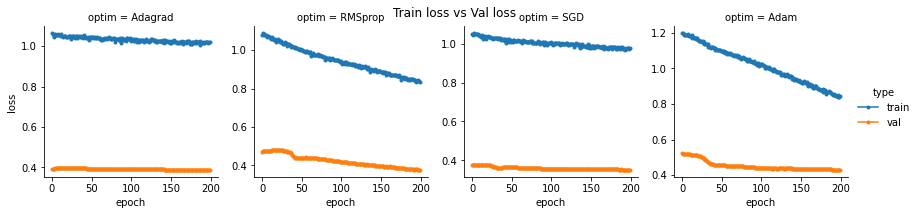

In [ ]:
var1 = 'optim'
df = load_exp_result('exp1_optim')

plot_loss_variation(var1, df, sharey=False)

## Result
### optim = Adam

# 2. Model Capacity

In [ ]:
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp2_hidn"
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

args.batch_size = 193
args.x_frames = 4
args.y_frames = 4
trainset = MyDataset(args.x_frames, args.y_frames, mydata, 0, int(0.6*len(mydata)))
valset = MyDataset(args.x_frames, args.y_frames, mydata, int(0.6*len(mydata)), int(0.8*len(mydata)))
testset = MyDataset(args.x_frames, args.y_frames, mydata, int(0.8*len(mydata)), int(len(mydata)))
partition = {'train': trainset, 'val':valset, 'test':testset}

args.input_dim = 1
args.hid_dim = 8
args.n_layers = 4

args.l2 = 0.00001
args.dropout = 0.0
args.use_bn = True

args.optim = 'Adam'
args.lr = 0.0001
args.epoch = 500

name_var1 = 'hid_dim'
name_var2 = 'n_layers'
list_var1 = [2, 4, 8, 16, 32, 64]
list_var2 = [2, 4, 6, 8]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch 9, Loss(train/val) 1.05139/0.41763. Took 0.04 sec
Epoch 10, Loss(train/val) 1.04982/0.41738. Took 0.05 sec
Epoch 11, Loss(train/val) 1.05698/0.41718. Took 0.05 sec
Epoch 12, Loss(train/val) 1.04872/0.41704. Took 0.04 sec
Epoch 13, Loss(train/val) 1.05299/0.41697. Took 0.04 sec
Epoch 14, Loss(train/val) 1.04889/0.41700. Took 0.04 sec
Epoch 15, Loss(train/val) 1.05041/0.41711. Took 0.04 sec
Epoch 16, Loss(train/val) 1.05114/0.41734. Took 0.06 sec
Epoch 17, Loss(train/val) 1.04668/0.41769. Took 0.04 sec
Epoch 18, Loss(train/val) 1.04293/0.41819. Took 0.04 sec
Epoch 19, Loss(train/val) 1.04417/0.41887. Took 0.04 sec
Epoch 20, Loss(train/val) 1.03695/0.41978. Took 0.04 sec
Epoch 21, Loss(train/val) 1.03223/0.42018. Took 0.05 sec
Epoch 22, Loss(train/val) 1.04689/0.42000. Took 0.05 sec
Epoch 23, Loss(train/val) 1.04750/0.41983. Took 0.04 sec
Epoch 24, Loss(train/val) 1.03906/0.41967. Took 0.04 sec
Epoch 25, Loss(train/val) 1.03758/0.41951. Took 0.04 

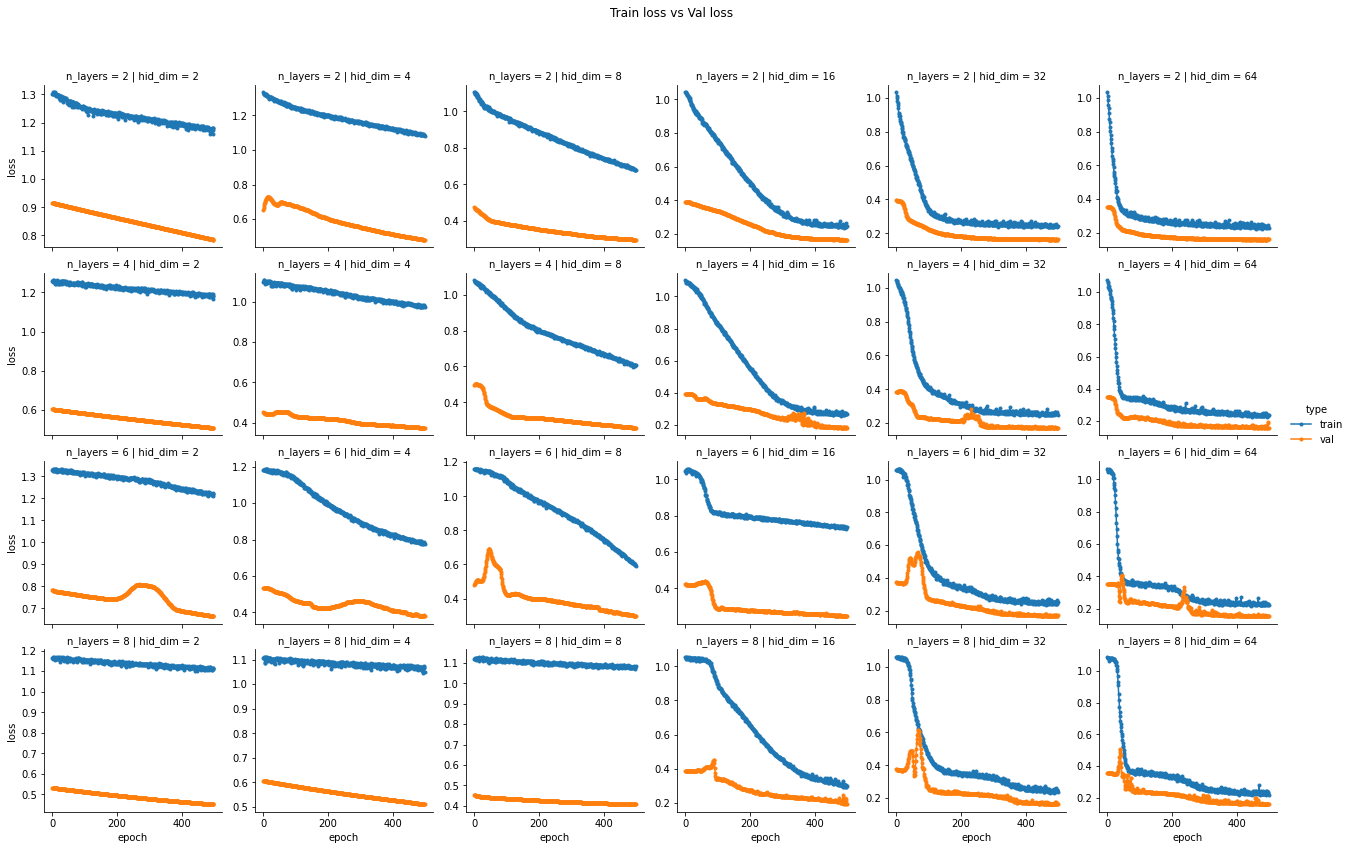

In [ ]:
var1 = 'hid_dim'
var2 = 'n_layers'
df = load_exp_result('exp2_hidn')

plot_loss_variation2(var1, var2, df, sharey=False)

## Results
### hid_dim = 16
### n_layers = 8

## 3. Learning Rate(lr)

In [ ]:
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp3_lr"
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

args.batch_size = 193
args.x_frames = 4
args.y_frames = 4
trainset = MyDataset(args.x_frames, args.y_frames, mydata, 0, int(0.6*len(mydata)))
valset = MyDataset(args.x_frames, args.y_frames, mydata, int(0.6*len(mydata)), int(0.8*len(mydata)))
testset = MyDataset(args.x_frames, args.y_frames, mydata, int(0.8*len(mydata)), int(len(mydata)))
partition = {'train': trainset, 'val':valset, 'test':testset}

args.input_dim = 1
args.hid_dim = 16
args.n_layers = 8

args.l2 = 0.00001
args.dropout = 0.0
args.use_bn = True

args.optim = 'Adam'
args.lr = 0.0001
args.epoch = 700

name_var1 = 'lr'
list_var1 = [0.00001, 0.00003, 0.0001, 0.0003]

for var1 in list_var1:
    setattr(args, name_var1, var1)
    print(args)
                
    setting, result = experiment(partition, deepcopy(args))
    save_exp_result(setting, result)

Namespace(batch_size=193, device='cuda', dropout=0.0, epoch=700, exp_name='exp3_lr', hid_dim=16, input_dim=1, l2=1e-05, lr=1e-05, n_layers=8, optim='Adam', use_bn=True, x_frames=4, y_frames=4)
Epoch 0, Loss(train/val) 1.03470/0.38240. Took 0.05 sec
Epoch 1, Loss(train/val) 1.03300/0.38340. Took 0.05 sec
Epoch 2, Loss(train/val) 1.02345/0.38426. Took 0.05 sec
Epoch 3, Loss(train/val) 1.03088/0.38500. Took 0.05 sec
Epoch 4, Loss(train/val) 1.02085/0.38565. Took 0.05 sec
Epoch 5, Loss(train/val) 1.03315/0.38621. Took 0.05 sec
Epoch 6, Loss(train/val) 1.02412/0.38669. Took 0.05 sec
Epoch 7, Loss(train/val) 1.02083/0.38710. Took 0.05 sec
Epoch 8, Loss(train/val) 1.03290/0.38747. Took 0.04 sec
Epoch 9, Loss(train/val) 1.02382/0.38778. Took 0.05 sec
Epoch 10, Loss(train/val) 1.02060/0.38805. Took 0.05 sec
Epoch 11, Loss(train/val) 1.03135/0.38829. Took 0.05 sec
Epoch 12, Loss(train/val) 1.02572/0.38849. Took 0.05 sec
Epoch 13, Loss(train/val) 1.03091/0.38867. Took 0.05 sec
Epoch 14, Loss(trai

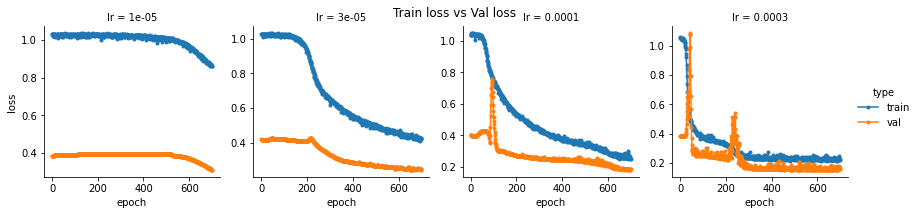

In [ ]:
var1 = 'lr'
df = load_exp_result('exp3_lr')

plot_loss_variation(var1, df, sharey=False)

In [ ]:
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp3_lr_deep"
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

args.batch_size = 193
args.x_frames = 4
args.y_frames = 4
trainset = MyDataset(args.x_frames, args.y_frames, mydata, 0, int(0.6*len(mydata)))
valset = MyDataset(args.x_frames, args.y_frames, mydata, int(0.6*len(mydata)), int(0.8*len(mydata)))
testset = MyDataset(args.x_frames, args.y_frames, mydata, int(0.8*len(mydata)), int(len(mydata)))
partition = {'train': trainset, 'val':valset, 'test':testset}

args.input_dim = 1
args.hid_dim = 16
args.n_layers = 8

args.l2 = 0.00001
args.dropout = 0.0
args.use_bn = True

args.optim = 'Adam'
args.lr = 0.0001
args.epoch = 1000

name_var1 = 'lr'
list_var1 = [0.00002, 0.00003, 0.00004, 0.00005]

for var1 in list_var1:
    setattr(args, name_var1, var1)
    print(args)
                
    setting, result = experiment(partition, deepcopy(args))
    save_exp_result(setting, result)

Namespace(batch_size=193, device='cuda', dropout=0.0, epoch=1000, exp_name='exp3_lr_deep', hid_dim=16, input_dim=1, l2=1e-05, lr=2e-05, n_layers=8, optim='Adam', use_bn=True, x_frames=4, y_frames=4)
Epoch 0, Loss(train/val) 1.03470/0.38242. Took 0.11 sec
Epoch 1, Loss(train/val) 1.03300/0.38343. Took 0.10 sec
Epoch 2, Loss(train/val) 1.02343/0.38429. Took 0.08 sec
Epoch 3, Loss(train/val) 1.03086/0.38506. Took 0.08 sec
Epoch 4, Loss(train/val) 1.02083/0.38571. Took 0.08 sec
Epoch 5, Loss(train/val) 1.03312/0.38628. Took 0.08 sec
Epoch 6, Loss(train/val) 1.02409/0.38678. Took 0.09 sec
Epoch 7, Loss(train/val) 1.02079/0.38721. Took 0.06 sec
Epoch 8, Loss(train/val) 1.03286/0.38759. Took 0.05 sec
Epoch 9, Loss(train/val) 1.02378/0.38792. Took 0.05 sec
Epoch 10, Loss(train/val) 1.02055/0.38821. Took 0.05 sec
Epoch 11, Loss(train/val) 1.03130/0.38847. Took 0.04 sec
Epoch 12, Loss(train/val) 1.02566/0.38870. Took 0.05 sec
Epoch 13, Loss(train/val) 1.03085/0.38890. Took 0.04 sec
Epoch 14, Los

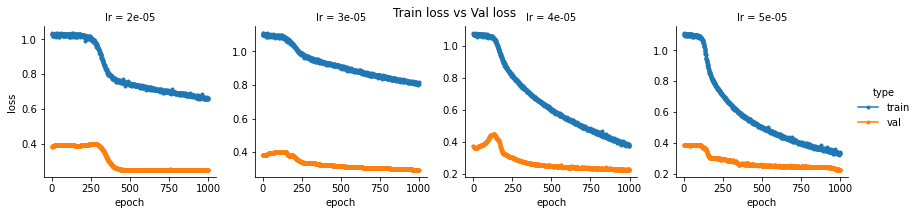

In [ ]:
var1 = 'lr'
df = load_exp_result('exp3_lr_deep')

plot_loss_variation(var1, df, sharey=False)

In [ ]:
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp3_lr_deep2"
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

args.batch_size = 193
args.x_frames = 4
args.y_frames = 4
trainset = MyDataset(args.x_frames, args.y_frames, mydata, 0, int(0.6*len(mydata)))
valset = MyDataset(args.x_frames, args.y_frames, mydata, int(0.6*len(mydata)), int(0.8*len(mydata)))
testset = MyDataset(args.x_frames, args.y_frames, mydata, int(0.8*len(mydata)), int(len(mydata)))
partition = {'train': trainset, 'val':valset, 'test':testset}

args.input_dim = 1
args.hid_dim = 16
args.n_layers = 8

args.l2 = 0.00001
args.dropout = 0.0
args.use_bn = True

args.optim = 'Adam'
args.lr = 0.0001
args.epoch = 5000

name_var1 = 'lr'
list_var1 = [0.00003, 0.00004, 0.00005]

for var1 in list_var1:
    setattr(args, name_var1, var1)
    print(args)
                
    setting, result = experiment(partition, deepcopy(args))
    save_exp_result(setting, result)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch 0, Loss(train/val) 1.06803/0.35077. Took 0.05 sec
Epoch 1, Loss(train/val) 1.07323/0.35086. Took 0.05 sec
Epoch 2, Loss(train/val) 1.07331/0.35092. Took 0.04 sec
Epoch 3, Loss(train/val) 1.06841/0.35097. Took 0.05 sec
Epoch 4, Loss(train/val) 1.06699/0.35100. Took 0.05 sec
Epoch 5, Loss(train/val) 1.06735/0.35102. Took 0.04 sec
Epoch 6, Loss(train/val) 1.07085/0.35102. Took 0.05 sec
Epoch 7, Loss(train/val) 1.07397/0.35102. Took 0.05 sec
Epoch 8, Loss(train/val) 1.06935/0.35100. Took 0.05 sec
Epoch 9, Loss(train/val) 1.07315/0.35098. Took 0.05 sec
Epoch 10, Loss(train/val) 1.07262/0.35095. Took 0.05 sec
Epoch 11, Loss(train/val) 1.07131/0.35092. Took 0.05 sec
Epoch 12, Loss(train/val) 1.07178/0.35088. Took 0.06 sec
Epoch 13, Loss(train/val) 1.07353/0.35084. Took 0.05 sec
Epoch 14, Loss(train/val) 1.07575/0.35080. Took 0.05 sec
Epoch 15, Loss(train/val) 1.07032/0.35076. Took 0.05 sec
Epoch 16, Loss(train/val) 1.06560/0.35071. Took 0.05 sec
Epoch

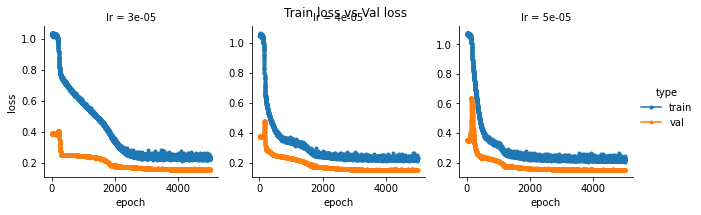

In [ ]:
var1 = 'lr'
df = load_exp_result('exp3_lr_deep2')

plot_loss_variation(var1, df, sharey=False)

## Results
### lr = 0.00004

## 4. L2 norm(l2)

In [ ]:
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp4_l2"
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

args.batch_size = 193
args.x_frames = 4
args.y_frames = 4
trainset = MyDataset(args.x_frames, args.y_frames, mydata, 0, int(0.6*len(mydata)))
valset = MyDataset(args.x_frames, args.y_frames, mydata, int(0.6*len(mydata)), int(0.8*len(mydata)))
testset = MyDataset(args.x_frames, args.y_frames, mydata, int(0.8*len(mydata)), int(len(mydata)))
partition = {'train': trainset, 'val':valset, 'test':testset}

args.input_dim = 1
args.hid_dim = 16
args.n_layers = 8

args.l2 = 0.00001
args.dropout = 0.0
args.use_bn = True

args.optim = 'Adam'
args.lr = 0.00004
args.epoch = 2800

name_var1 = 'l2'
list_var1 = [0.000003, 0.00001, 0.00003, 0.0001]

for var1 in list_var1:
    setattr(args, name_var1, var1)
    print(args)
                
    setting, result = experiment(partition, deepcopy(args))
    save_exp_result(setting, result)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch 601, Loss(train/val) 0.55843/0.27868. Took 0.05 sec
Epoch 602, Loss(train/val) 0.55182/0.27826. Took 0.05 sec
Epoch 603, Loss(train/val) 0.55322/0.27897. Took 0.05 sec
Epoch 604, Loss(train/val) 0.54376/0.28034. Took 0.06 sec
Epoch 605, Loss(train/val) 0.55819/0.28074. Took 0.05 sec
Epoch 606, Loss(train/val) 0.54330/0.28034. Took 0.05 sec
Epoch 607, Loss(train/val) 0.54430/0.27978. Took 0.04 sec
Epoch 608, Loss(train/val) 0.55404/0.27783. Took 0.04 sec
Epoch 609, Loss(train/val) 0.54497/0.27543. Took 0.05 sec
Epoch 610, Loss(train/val) 0.56123/0.27467. Took 0.05 sec
Epoch 611, Loss(train/val) 0.54252/0.27298. Took 0.05 sec
Epoch 612, Loss(train/val) 0.54891/0.27272. Took 0.04 sec
Epoch 613, Loss(train/val) 0.54857/0.27242. Took 0.04 sec
Epoch 614, Loss(train/val) 0.54161/0.27237. Took 0.05 sec
Epoch 615, Loss(train/val) 0.54345/0.27225. Took 0.04 sec
Epoch 616, Loss(train/val) 0.54888/0.27302. Took 0.04 sec
Epoch 617, Loss(train/val) 0.54492/0

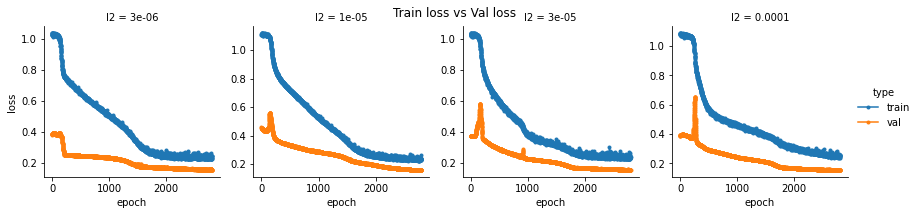

In [ ]:
var1 = 'l2'
df = load_exp_result('exp4_l2')

#plot_acc(var1, var2, df)
plot_loss_variation(var1, df, sharey=False) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
#plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True)

## Results
### l2 = 0.00001

## 5. Dropout

In [ ]:
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp5_dropout1"
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

args.batch_size = 193
args.x_frames = 4
args.y_frames = 4
trainset = MyDataset(args.x_frames, args.y_frames, mydata, 0, int(0.6*len(mydata)))
valset = MyDataset(args.x_frames, args.y_frames, mydata, int(0.6*len(mydata)), int(0.8*len(mydata)))
testset = MyDataset(args.x_frames, args.y_frames, mydata, int(0.8*len(mydata)), int(len(mydata)))
partition = {'train': trainset, 'val':valset, 'test':testset}

args.input_dim = 1
args.hid_dim = 16
args.n_layers = 8

args.l2 = 0.00001
args.dropout = 0.0
args.use_bn = True

args.optim = 'Adam'
args.lr = 0.00005
args.epoch = 2800

name_var1 = 'dropout'
list_var1 = [0.0, 0.2, 0.4, 0.6, 0.8]

for var1 in list_var1:
    setattr(args, name_var1, var1)
    print(args)
                
    setting, result = experiment(partition, deepcopy(args))
    save_exp_result(setting, result)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch 601, Loss(train/val) 0.56332/0.28251. Took 0.05 sec
Epoch 602, Loss(train/val) 0.53156/0.27958. Took 0.05 sec
Epoch 603, Loss(train/val) 0.54083/0.28326. Took 0.05 sec
Epoch 604, Loss(train/val) 0.55543/0.28879. Took 0.06 sec
Epoch 605, Loss(train/val) 0.55941/0.29313. Took 0.05 sec
Epoch 606, Loss(train/val) 0.55897/0.28360. Took 0.05 sec
Epoch 607, Loss(train/val) 0.56134/0.27717. Took 0.06 sec
Epoch 608, Loss(train/val) 0.56825/0.27703. Took 0.05 sec
Epoch 609, Loss(train/val) 0.52418/0.27977. Took 0.05 sec
Epoch 610, Loss(train/val) 0.54266/0.27773. Took 0.05 sec
Epoch 611, Loss(train/val) 0.53986/0.27790. Took 0.05 sec
Epoch 612, Loss(train/val) 0.56873/0.27361. Took 0.06 sec
Epoch 613, Loss(train/val) 0.54834/0.27158. Took 0.05 sec
Epoch 614, Loss(train/val) 0.55543/0.27110. Took 0.05 sec
Epoch 615, Loss(train/val) 0.54405/0.27034. Took 0.04 sec
Epoch 616, Loss(train/val) 0.53875/0.26962. Took 0.05 sec
Epoch 617, Loss(train/val) 0.56395/0

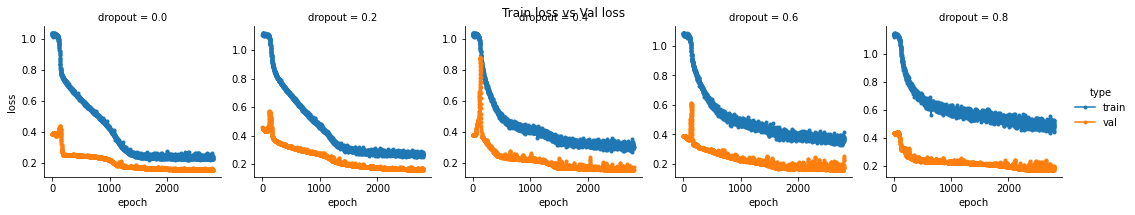

In [ ]:
var1 = 'dropout'
df = load_exp_result('exp5_dropout1')

#plot_acc(var1, var2, df)
plot_loss_variation(var1, df, sharey=False) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
#plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True)

## Results
### dropout = 0.2

# Prediction

Namespace(batch_size=193, device='cpu', dropout=0.2, epoch=3000, exp_name='exp0_test', hid_dim=16, input_dim=1, l2=1e-05, lr=5e-05, n_layers=8, optim='Adam', use_bn=True, x_frames=4, y_frames=4)
Epoch 0, Loss(train/val) 1.02559/0.37242. Took 0.37 sec
Epoch 1, Loss(train/val) 1.01741/0.37350. Took 0.09 sec
Epoch 2, Loss(train/val) 1.01566/0.37443. Took 0.09 sec
Epoch 3, Loss(train/val) 1.01762/0.37527. Took 0.10 sec
Epoch 4, Loss(train/val) 1.01729/0.37601. Took 0.11 sec
Epoch 5, Loss(train/val) 1.01731/0.37666. Took 0.10 sec
Epoch 6, Loss(train/val) 1.02222/0.37723. Took 0.10 sec
Epoch 7, Loss(train/val) 1.01695/0.37772. Took 0.09 sec
Epoch 8, Loss(train/val) 1.01266/0.37817. Took 0.10 sec
Epoch 9, Loss(train/val) 1.02451/0.37858. Took 0.10 sec
Epoch 10, Loss(train/val) 1.02597/0.37895. Took 0.11 sec
Epoch 11, Loss(train/val) 1.02043/0.37929. Took 0.09 sec
Epoch 12, Loss(train/val) 1.02386/0.37961. Took 0.09 sec
Epoch 13, Loss(train/val) 1.02193/0.37990. Took 0.10 sec
Epoch 14, Loss(tr

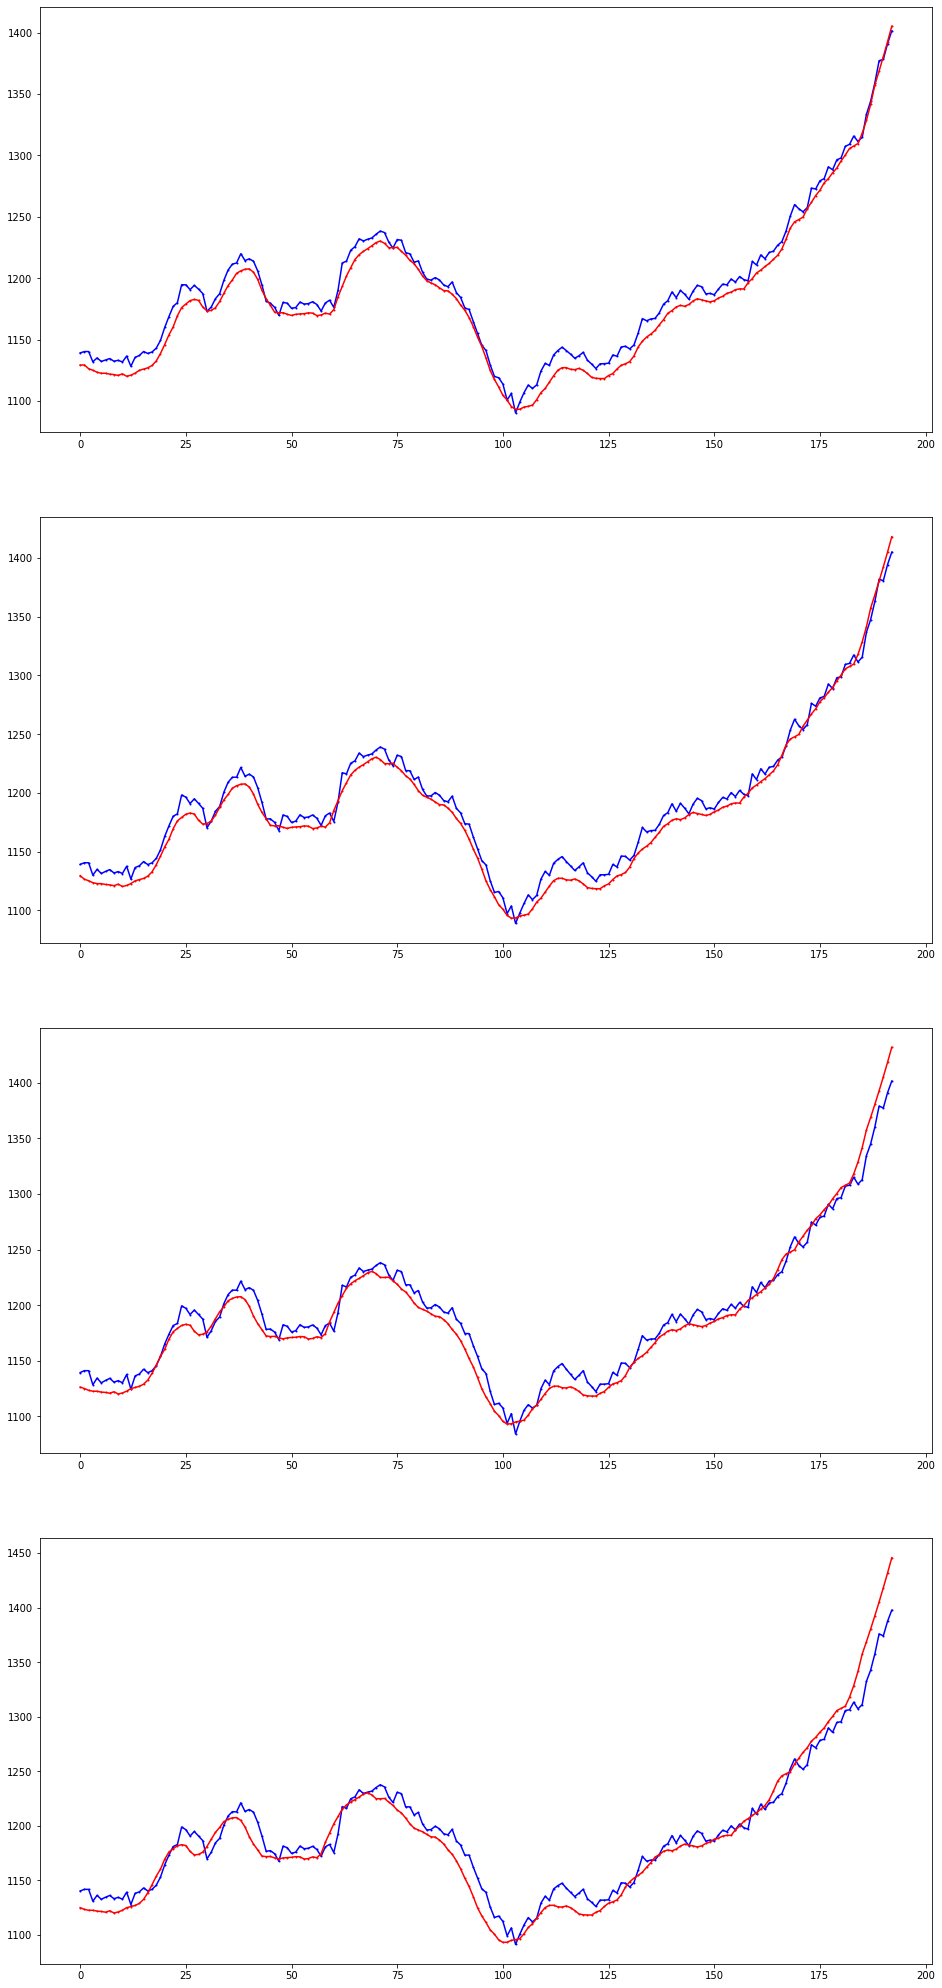

In [21]:
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp0_test"
args.device = 'cpu'

args.batch_size = 193
args.x_frames = 4
args.y_frames = 4
trainset = MyDataset(args.x_frames, args.y_frames, mydata, 0, int(0.6*len(mydata)))
valset = MyDataset(args.x_frames, args.y_frames, mydata, int(0.6*len(mydata)), int(0.8*len(mydata)))
testset = MyDataset(args.x_frames, args.y_frames, mydata, int(0.8*len(mydata)), int(len(mydata)))
partition = {'train': trainset, 'val':valset, 'test':testset}

args.input_dim = 1
args.hid_dim = 16
args.n_layers = 8

args.l2 = 0.00001
args.dropout = 0.2
args.use_bn = True

args.optim = 'Adam'
args.lr = 0.00005
args.epoch = 3000

name_var1 = 'hid_dim'
list_var1 = [16]

for var1 in list_var1:
    setattr(args, name_var1, var1)
    print(args)
                
    setting, result = prediction(partition, deepcopy(args))
    save_exp_result(setting, result)